 # importing all necessary libraries
 
 

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import cv2
from tensorflow import keras
from PIL import Image
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Dense, Dropout,MaxPooling2D,ReLU,Flatten ,Layer
from tensorflow.keras.optimizers import Adam
from collections import Counter
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,precision_recall_curve, roc_curve
from sklearn.utils.class_weight import compute_class_weight

2024-07-10 05:43:43.898647: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 05:43:43.898769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 05:43:44.036118: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# creating datsets after splitting the data with Stratify


In [2]:
dataset_dir = "/kaggle/input/natural-disasters-sat-images/dataset"
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"
val_dir = "/kaggle/working/val"

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Function to split data with stratification
def split_data(category, source_dir, train_dir, test_dir, val_dir, train_size=0.7, val_size=0.15):
    category_path = os.path.join(source_dir, category)
    files = os.listdir(category_path)
    
    # Split into train and temp
    train_temp_files, test_files = train_test_split(files, test_size=0.3, stratify=[category] * len(files))  # Stratify by category
    
    # Further split temp into val and train
    train_files, val_files = train_test_split(train_temp_files, test_size=0.5, stratify=[category] * len(train_temp_files))  # Stratify by category
    
    # Copy files to respective directories
    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(train_dir, category))
    
    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(test_dir, category))
    
    for file in val_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(val_dir, category))

# Split data for each category
categories = ['drought', 'earthquake', 'hurricane', 'landslide', 'no damage', 'wild fire']

for category in categories:
    # Create subdirectories for each category in train, test, val directories
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    
    # Split and copy data with stratification
    split_data(category, dataset_dir, train_dir, test_dir, val_dir)

In [3]:
print("\nOverall class distribution after splitting :")
for category in categories:
    train_files = os.listdir(os.path.join(train_dir, category))
    print(f"Class '{category}': {len(train_files)} samples")


Overall class distribution after splitting :
Class 'drought': 1780 samples
Class 'earthquake': 432 samples
Class 'hurricane': 1788 samples
Class 'landslide': 693 samples
Class 'no damage': 1760 samples
Class 'wild fire': 1781 samples


# creating ImageGenerators for Preprocessing & data Augmentation


In [4]:
IMG_SIZE = 200
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=35,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    vertical_flip=True,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest')



# Create generators for each category
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
   
)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  
)


Found 8234 images belonging to 6 classes.
Found 8237 images belonging to 6 classes.
Found 7063 images belonging to 6 classes.


In [5]:
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)

Class Indices: {'drought': 0, 'earthquake': 1, 'hurricane': 2, 'landslide': 3, 'no damage': 4, 'wild fire': 5}


# computing class weights to pass to the model while training

In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Get class counts from the generators
class_counts = np.unique(train_generator.classes, return_counts=True)[1]

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
# Convert to dictionary
class_weight_dict = dict(zip(np.unique(train_generator.classes), class_weights))
# Print class weights
print("Class Weights:")
for class_label, weight in class_weight_dict.items():
    print(f"{class_label}: {weight}")


Class Weights:
0: 0.7709737827715356
1: 3.1766975308641974
2: 0.767524235645041
3: 1.9802789802789802
4: 0.7797348484848485
5: 0.7705408946284859


# visualizing the class distribution in( train,test,validation)

Training Class Distribution:
drought: 1780
earthquake: 432
hurricane: 1788
landslide: 693
no damage: 1760
wild fire: 1781
Validation Class Distribution:
drought: 1781
earthquake: 433
hurricane: 1789
landslide: 693
no damage: 1760
wild fire: 1781
Test Class Distribution:
drought: 1527
earthquake: 372
hurricane: 1534
landslide: 594
no damage: 1509
wild fire: 1527


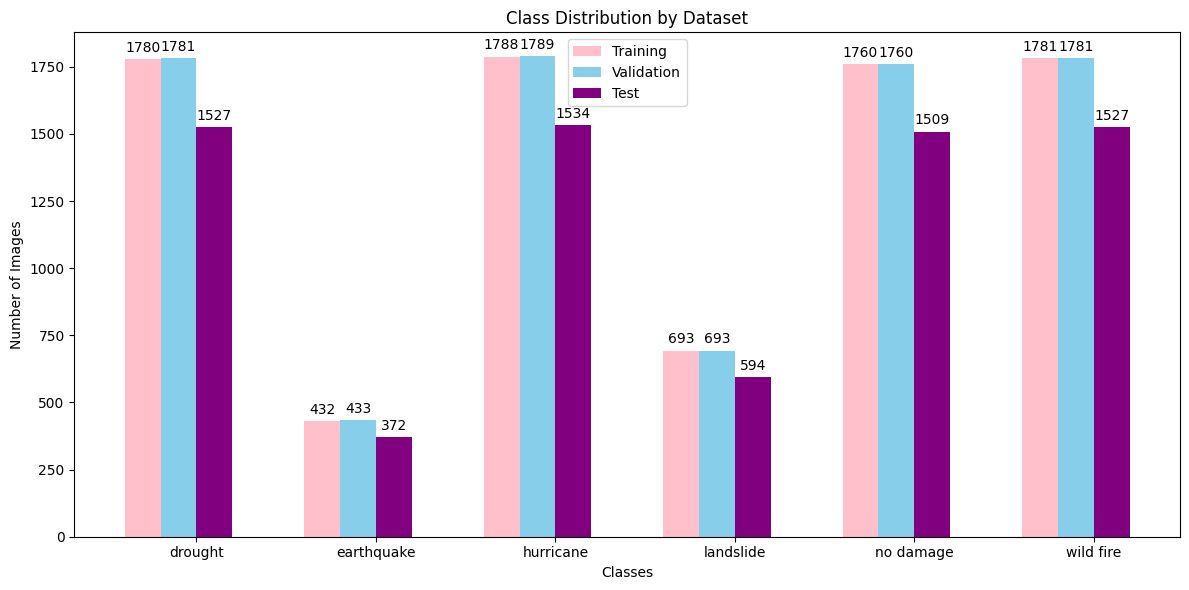

In [7]:
def get_class_distribution(generator):
    class_counts = {class_name: 0 for class_name in generator.class_indices.keys()}
    class_indices = generator.classes  # Directly get the class indices of all images
    for class_index in class_indices:
        class_name = list(generator.class_indices.keys())[class_index]
        class_counts[class_name] += 1
    return class_counts

def display_class_distribution(distribution, dataset_name):
    print(f"{dataset_name} Class Distribution:")
    for class_name, count in distribution.items():
        print(f"{class_name}: {count}")

def plot_combined_class_distribution(train_dist, val_dist, test_dist, train_other_dist=None):
    class_names = list(train_dist.keys())
    train_counts = [train_dist.get(cls, 0) for cls in class_names]
    val_counts = [val_dist.get(cls, 0) for cls in class_names]
    test_counts = [test_dist.get(cls, 0) for cls in class_names]
    
    if train_other_dist:
        train_other_counts = [train_other_dist.get(cls, 0) for cls in class_names]
    else:
        train_other_counts = [0] * len(class_names)  
    
    x = np.arange(len(class_names))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    
    rects1 = ax.bar(x - width*1.5, train_counts, width, label='Training', color='pink')
    rects2 = ax.bar(x - width/2, val_counts, width, label='Validation', color='skyblue')
    rects3 = ax.bar(x + width/2, test_counts, width, label='Test', color='purple')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title('Class Distribution by Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()
        
        
        
train_class_distribution = get_class_distribution(train_generator)
val_class_distribution = get_class_distribution(val_generator)
test_class_distribution = get_class_distribution(test_generator)

# Display class distributions
display_class_distribution(train_class_distribution, "Training")
display_class_distribution(val_class_distribution, "Validation")
display_class_distribution(test_class_distribution, "Test")

# Plot combined class distribution
plot_combined_class_distribution(train_class_distribution, val_class_distribution, test_class_distribution)

# displaying images  samples from each class

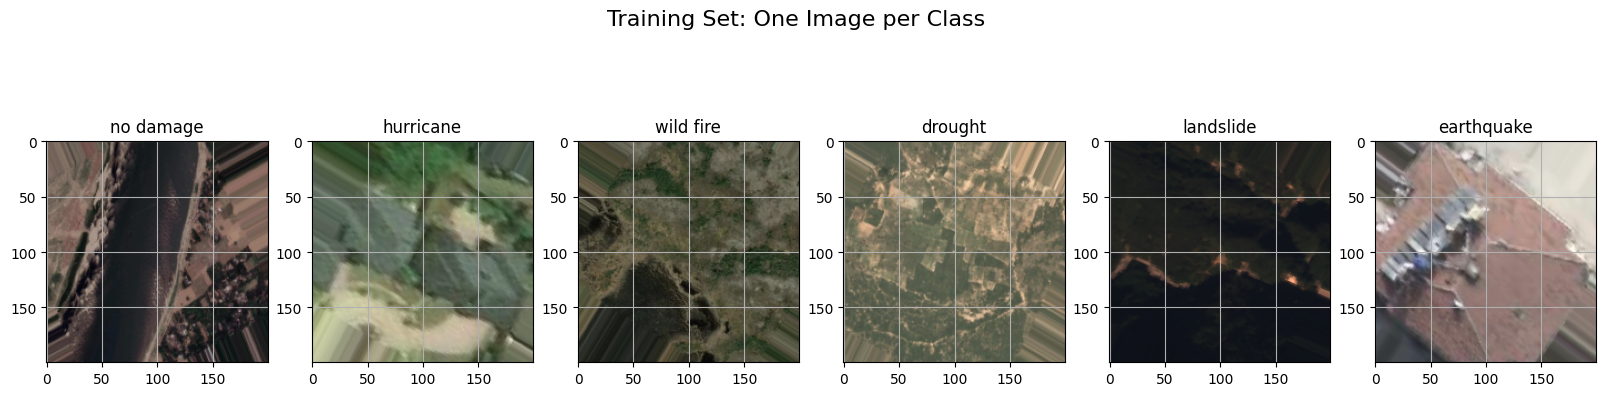

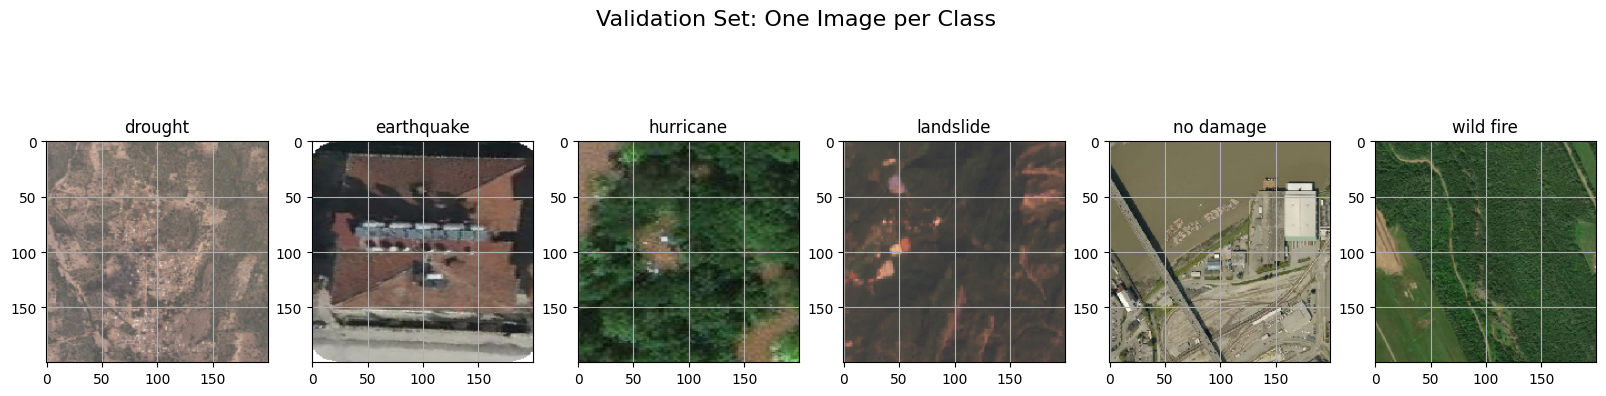

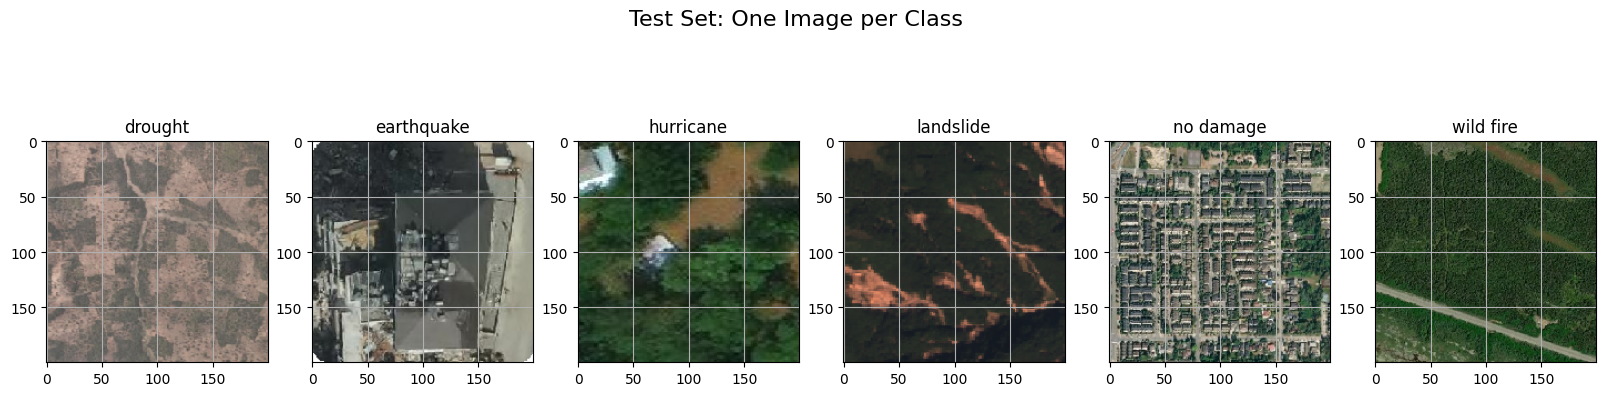

In [8]:
def get_one_image_per_class(generator):
    class_images = {}
    class_names = list(generator.class_indices.keys())

    for batch_images, batch_labels in generator:
        for image, label in zip(batch_images, batch_labels):
            class_idx = np.argmax(label)  # Get the class index
            class_name = class_names[class_idx]
            if class_name not in class_images:
                class_images[class_name] = image
            if len(class_images) == len(class_names):
                return class_images

def plot_images(images, dataset_name):
    num_classes = len(images)
    fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))
    fig.suptitle(f'{dataset_name} Set: One Image per Class', fontsize=16)
    for idx, (class_name, image) in enumerate(images.items()):
        ax = axes[idx]
        ax.imshow(image.squeeze())  
        ax.set_title(class_name)
        ax.grid(True)
        ax.axis('on') 
    plt.show()

# Get one image per class for each dataset
train_class_images = get_one_image_per_class(train_generator)
val_class_images = get_one_image_per_class(val_generator)
test_class_images = get_one_image_per_class(test_generator)

# Plot images
plot_images(train_class_images, "Training")
plot_images(val_class_images, "Validation")
plot_images(test_class_images, "Test")

# building the model ...

In [9]:
model = models.Sequential([
    Conv2D(32, (3, 3), activation="relu",padding="same", input_shape=(200, 200, 3)),
    MaxPooling2D(pool_size=(2, 2)),
   
    
    Conv2D(64, (3, 3), activation="relu",padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
   
    
    Conv2D(128, (3, 3), activation="relu",padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    
    Conv2D(128, (3, 3), activation="relu",padding="same"),
    MaxPooling2D(pool_size=(2, 2)),

    
    Conv2D(256, (3, 3), activation="relu",padding="same"), 
    MaxPooling2D(pool_size=(2, 2)),
    

    Flatten(),

    Dense(2048, activation="relu"),  
    Dropout(0.5),
    Dense(6, activation="softmax")
])

model.summary()

optimizer = Adam()
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │    18,876,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,424,710 (74.10 MB)

 Trainable params: 19,424,710 (74.10 MB)

 Non-trainable params: 0 (0.00 B)

# defining CallBacks for training 

In [10]:
learning_rate = 0.0002

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: float(learning_rate * tf.math.exp(-epoch / 10)), verbose=1
)

early_stopping = EarlyStopping(monitor ='val_loss', patience = 4, restore_best_weights = True)

# training the model

In [11]:
history = model.fit(train_generator,
                    epochs = 17,
                    validation_data = val_generator,
                    callbacks = [early_stopping,lr_scheduler],
                    class_weight=class_weight_dict)


Epoch 1: LearningRateScheduler setting learning rate to 0.00019999999494757503.
Epoch 1/17


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-10 05:48:08.895730: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.94275, expected 3.24734
2024-07-10 05:48:08.895786: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.4544, expected 3.75899
2024-07-10 05:48:08.895795: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.57826, expected 4.88285
2024-07-10 05:48:08.895803: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.19474, expected 4.49933
2024-07-10 05:48:08.895811: E external/local_xla/xla/service/gpu/buffer_comparator.cc:113

  1/258 ━━━━━━━━━━━━━━━━━━━━ 57:34 13s/step - accuracy: 0.2188 - loss: 1.6597 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1720590495.396834     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720590495.419905     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


144/258 ━━━━━━━━━━━━━━━━━━━━ 38s 339ms/step - accuracy: 0.5006 - loss: 1.2306 - precision: 0.7123 - recall: 0.3180

2024-07-10 05:49:05.184675: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 39999: 2.29209, expected 1.95991
2024-07-10 05:49:05.184741: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 40000: 2.94635, expected 2.28207
2024-07-10 05:49:05.184750: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 40001: 5.13353, expected 4.46925
2024-07-10 05:49:05.184758: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 40002: 5.24155, expected 4.57727
2024-07-10 05:49:05.184766: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 40003: 4.26589, expected 3.60161
2024-07-10 05:49:05.184774: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 40004: 5.31433, expected 4.65005
2024-07-10 05:49:05.184782: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 40005: 5.23891, expected 4.57463
2024-07-10 05:49:05.184789:

257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.5922 - loss: 1.0387 - precision: 0.7624 - recall: 0.4484

W0000 00:00:1720590586.328750     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-07-10 05:50:04.818889: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.37177, expected 2.67653
2024-07-10 05:50:04.818972: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.20155, expected 3.50631
2024-07-10 05:50:04.818994: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.58612, expected 3.89089
2024-07-10 05:50:04.819006: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.32952, expected 3.63428
2024-07-10 05:50:04.819017: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.96743, expected 4.2722
2024-07-10 05:50:04.819028: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.41897, expected 3.72373
2024-07-10 05:50:04.819039: E external/local_xla/xla/service/gpu/b

258/258 ━━━━━━━━━━━━━━━━━━━━ 124s 431ms/step - accuracy: 0.5934 - loss: 1.0361 - precision: 0.7630 - recall: 0.4501 - val_accuracy: 0.9062 - val_loss: 0.2869 - val_precision: 0.9127 - val_recall: 0.8977 - learning_rate: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00018096747226081789.
Epoch 2/17
258/258 ━━━━━━━━━━━━━━━━━━━━ 107s 406ms/step - accuracy: 0.8737 - loss: 0.3484 - precision: 0.8840 - recall: 0.8640 - val_accuracy: 0.9153 - val_loss: 0.2352 - val_precision: 0.9206 - val_recall: 0.9099 - learning_rate: 1.8097e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00016374615370295942.
Epoch 3/17
258/258 ━━━━━━━━━━━━━━━━━━━━ 109s 411ms/step - accuracy: 0.9062 - loss: 0.2556 - precision: 0.9142 - recall: 0.8995 - val_accuracy: 0.9401 - val_loss: 0.1920 - val_precision: 0.9469 - val_recall: 0.9337 - learning_rate: 1.6375e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00014816364273428917.
Epoch 4/17
258/258 ━━━━━━━━━━━━━━━━━━━━ 10

# evaluation and visaulization of the results

In [12]:
# Evaluate the model on the test data
evaluation_results = model.evaluate(test_generator)

# Extract the evaluation metrics
test_loss = evaluation_results[0]
test_accuracy = evaluation_results[1]

# Print the evaluation results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9716 - loss: 0.1054 - precision: 0.9764 - recall: 0.9672

2024-07-10 06:15:22.099013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 40067: 2.57398, expected 2.13085
2024-07-10 06:15:22.099304: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 71599: 3.36118, expected 2.91805
2024-07-10 06:15:22.099404: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 79856: 3.02137, expected 2.57824
2024-07-10 06:15:22.099424: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 79999: 2.80923, expected 2.3661
2024-07-10 06:15:22.099438: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 80000: 4.73629, expected 3.98435
2024-07-10 06:15:22.099452: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 80001: 6.0718, expected 5.31985
2024-07-10 06:15:22.099468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 80003: 5.2095, expected 4.45756
2024-07-10 06:15:22.099482: E 

221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.9716 - loss: 0.1059 - precision: 0.9764 - recall: 0.9673
Test Loss: 0.16446149349212646
Test Accuracy: 0.9705507755279541


W0000 00:00:1720592123.796045     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


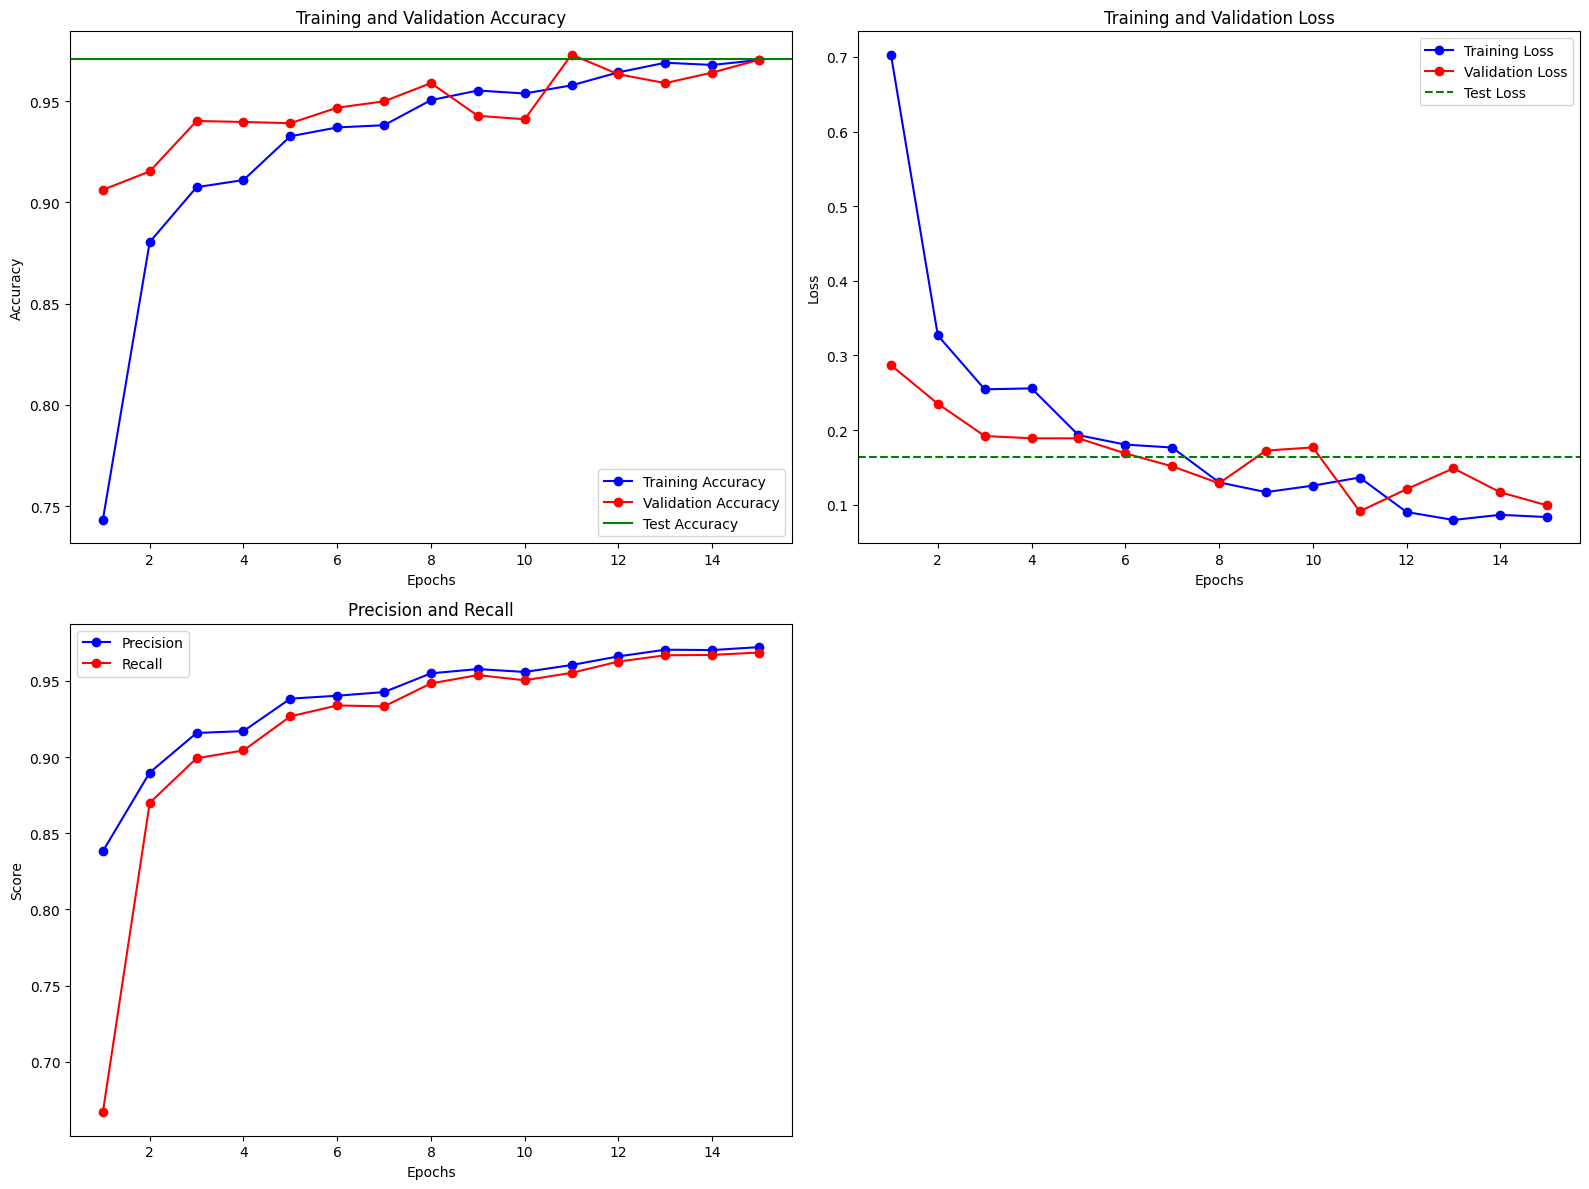

In [13]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
recall = history.history['recall']

epochs = range(1, len(acc) + 1)

# Plotting Training and Validation Accuracy with Test Accuracy
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'red', linestyle='-', marker='o', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='green', linestyle='-', label='Test Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'red', linestyle='-', marker='o', label='Validation Loss')
plt.axhline(y=test_loss, color='green', linestyle='--', label='Test Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()





# Plotting Precision and Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, precision, 'bo-', label='Precision')
plt.plot(epochs, recall, 'red', linestyle='-', marker='o', label='Recall')
plt.title('Precision and Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

  3/221 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step  

W0000 00:00:1720592125.629368     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step


W0000 00:00:1720592141.920530     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


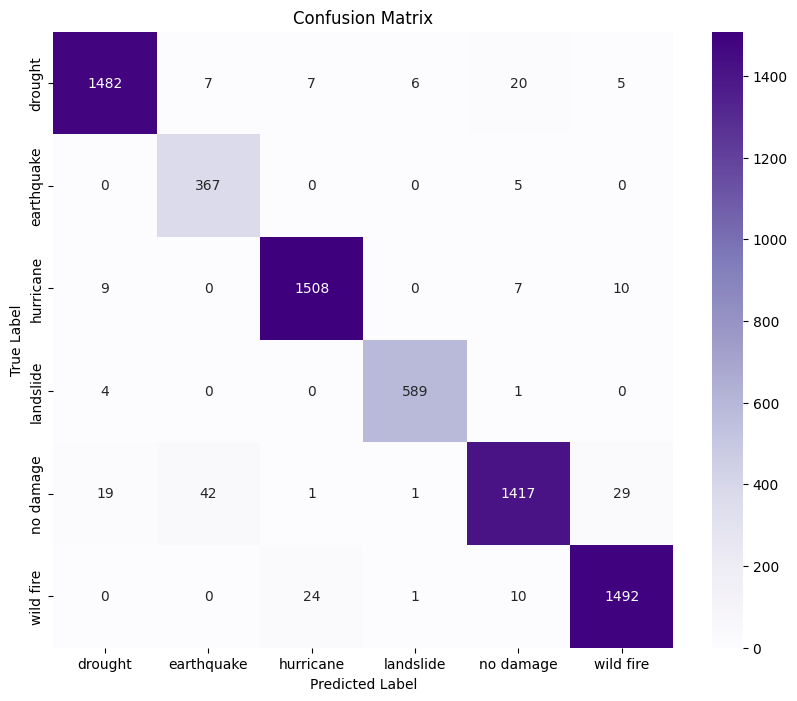

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

221/221 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step
Class drought: Precision = 0.9789, Recall = 0.9705, F1-score = 0.9747
Class earthquake: Precision = 0.8822, Recall = 0.9866, F1-score = 0.9315
Class hurricane: Precision = 0.9792, Recall = 0.9831, F1-score = 0.9811
Class landslide: Precision = 0.9866, Recall = 0.9916, F1-score = 0.9891
Class no damage: Precision = 0.9705, Recall = 0.9390, F1-score = 0.9545
Class wild fire: Precision = 0.9714, Recall = 0.9771, F1-score = 0.9742


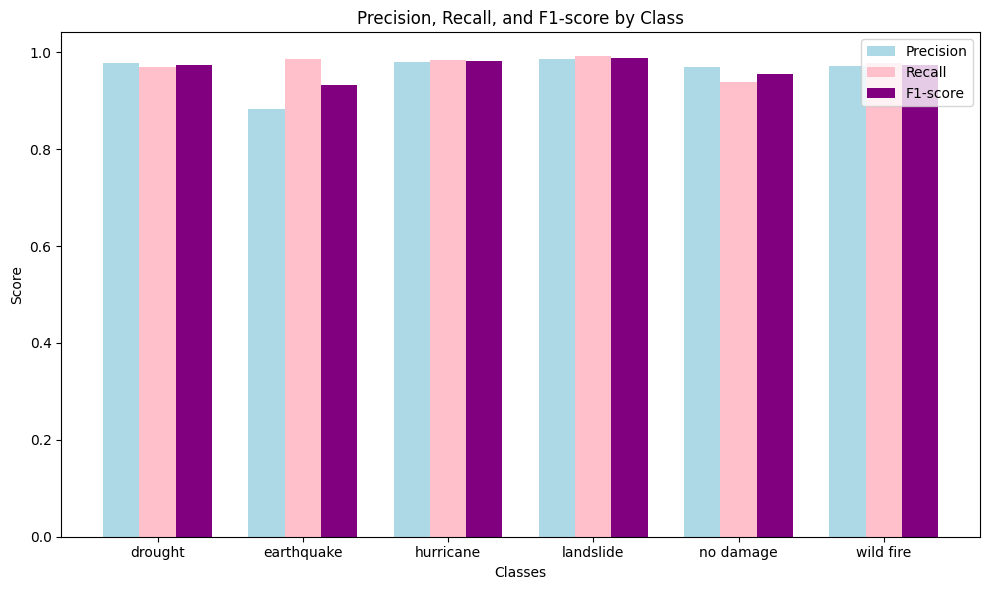

In [15]:
from sklearn.metrics import precision_recall_fscore_support
predictions = model.predict(test_generator)
true_labels = test_generator.classes

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=np.arange(len(class_labels)))

# Print metrics for each class
for i, cls in enumerate(class_labels):
    print(f"Class {cls}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, F1-score = {f1_score[i]:.4f}")

# Visualize precision, recall, and F1-score for each class
plt.figure(figsize=(10, 6))
bar_width = 0.25
index = np.arange(len(class_labels))

plt.bar(index, precision, color='lightblue', width=bar_width, label='Precision')
plt.bar(index + bar_width, recall, color='pink', width=bar_width, label='Recall')
plt.bar(index + 2 * bar_width, f1_score, color='purple', width=bar_width, label='F1-score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score by Class')
plt.xticks(index + bar_width, class_labels)
plt.legend()

plt.tight_layout()
plt.show()

221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step


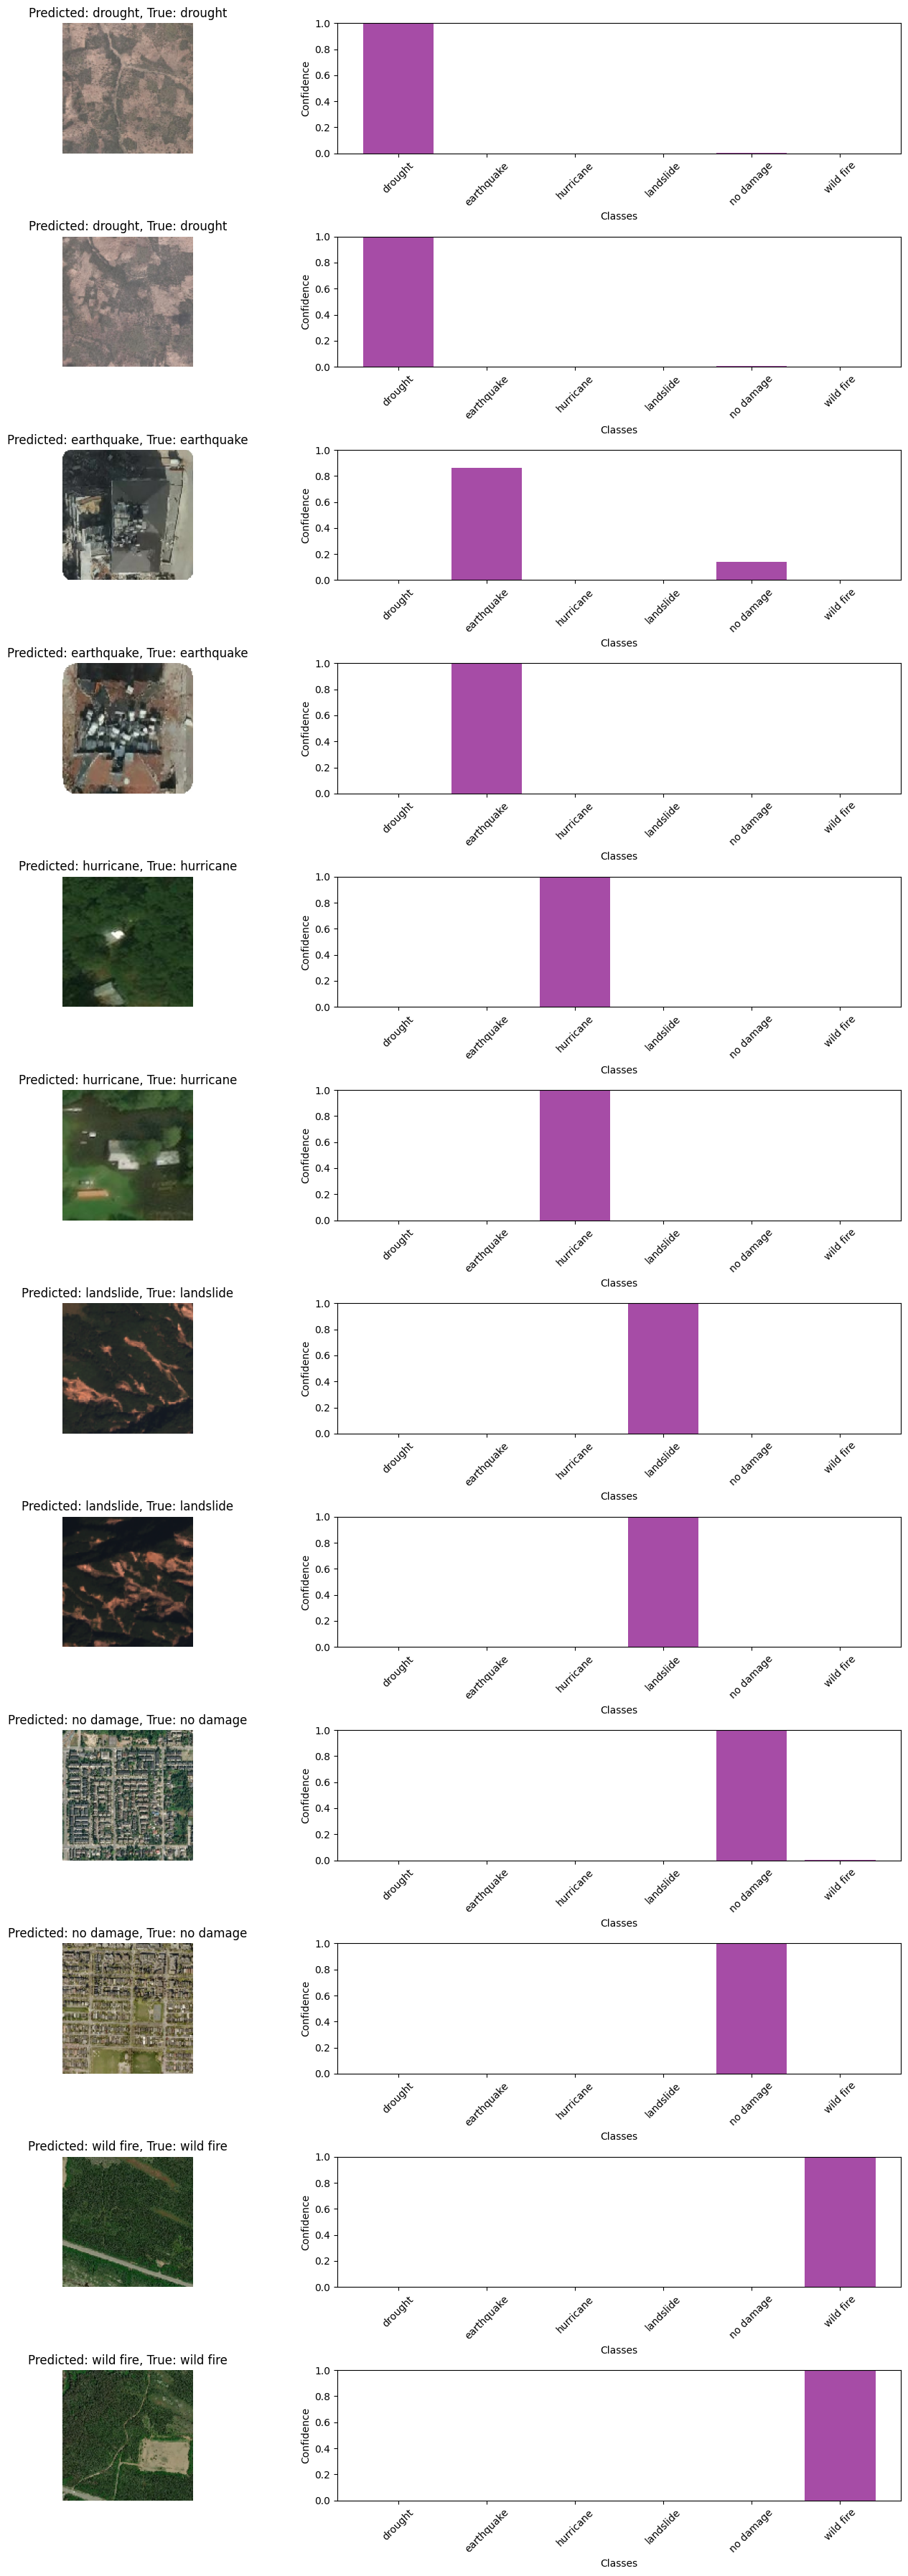

In [16]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def display_correctly_classified_images(model, generator, class_indices, num_images_per_class=2):
    class_labels = list(class_indices.keys())
    generator.reset()

    # Get predictions and true labels
    predictions = model.predict(generator, steps=int(np.ceil(len(generator.classes) / generator.batch_size)))
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    
    # Dictionary to store correctly classified indices per class
    correctly_classified = {label: [] for label in class_labels}
    for idx, (pred, true) in enumerate(zip(predicted_classes, true_classes)):
        if pred == true:
            correctly_classified[class_labels[true]].append(idx)
    
    # Determine the total number of plots
    total_plots = sum(min(len(correctly_classified[cls]), num_images_per_class) for cls in class_labels) * 2
    rows = len(class_labels) * num_images_per_class
    cols = 2

    plt.figure(figsize=(15, 3 * rows))
    subplot_idx = 1
    for class_label in class_labels:
        indices = correctly_classified[class_label]
        if indices:
            chosen_indices = indices[:num_images_per_class]
            for i, idx in enumerate(chosen_indices):
                img_path = generator.filepaths[idx]
                img_loaded = image.load_img(img_path, target_size=(128, 128))
                img_array = image.img_to_array(img_loaded)
                img_array /= 255.0

                # Display the image
                plt.subplot(rows, cols, subplot_idx)
                plt.imshow(img_array)
                plt.axis('off')
                plt.title(f"Predicted: {class_label}, True: {class_label}")
                subplot_idx += 1

                # Display the confidence bar plot
                plt.subplot(rows, cols, subplot_idx)
                plt.bar(class_labels, predictions[idx], color='purple', alpha=0.70)
                plt.xlabel('Classes')
                plt.ylabel('Confidence')
                plt.ylim([0, 1])
                plt.xticks(rotation=45)
                subplot_idx += 1

    plt.tight_layout()
    plt.show()

# Display correctly classified images with confidence scores
display_correctly_classified_images(model, test_generator, test_generator.class_indices, num_images_per_class=2)

        
      